In [1]:
!pip install pandas
!pip install nltk
!pip install numpy
!pip install textblob 
!pip install imbalanced-learn


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import spacy
from transformers import pipeline, BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch
from collections import Counter

# Set random seed for reproducibility
import random
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
nlp = spacy.load('en_core_web_sm')


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
2024-12-22 11:35:38.430339: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-22 11:35:38.447295: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-22 11:35:38.467506: E external/local_xla/xla/stream_executo

In [3]:

try:
    bodies = pd.read_csv("train_bodies.csv")
    stances = pd.read_csv("train_stances.csv")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure that the files 'train_bodies.csv' and 'train_stances.csv' are in the correct directory.")
    raise

data = pd.merge(stances, bodies, on="Body ID")

In [4]:
print(data.columns)
print(data.describe)


Index(['Headline', 'Body ID', 'Stance', 'articleBody'], dtype='object')
<bound method NDFrame.describe of                                                 Headline  Body ID     Stance  \
0      Police find mass graves with at least '15 bodi...      712  unrelated   
1               Seth Rogen to Play Apple’s Steve Wozniak      712    discuss   
2      Mexico police find mass grave near site 43 stu...      712  unrelated   
3      Mexico Says Missing Students Not Found In Firs...      712  unrelated   
4      New iOS 8 bug can delete all of your iCloud do...      712  unrelated   
...                                                  ...      ...        ...   
49967  Amazon Is Opening a Brick-and-Mortar Store in ...      464      agree   
49968  Elon University has not banned the term ‘fresh...      362      agree   
49969  Fake BBC News website set up to carry Charlie ...      915      agree   
49970  Apple was forced to nix key health features fr...      407    discuss   
49971  If you 

In [5]:
import pandas as pd
import spacy
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from tqdm import tqdm
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob

# Load SpaCy model for NER
nlp = spacy.load("en_core_web_sm")

# Initialize NLTK lemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab')
lemmatizer = WordNetLemmatizer()

# Preprocessing: Tokenization, Lemmatization, and Stance Detection
def preprocess_text(text):
    # Tokenization and Lemmatization
    tokens = word_tokenize(text.lower())
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens if token.isalpha()]
    return " ".join(lemmatized_tokens)

def preprocess_data(data):
    # Apply text preprocessing on both headline and body
    data['clean_headline'] = data['Headline'].apply(preprocess_text)
    data['clean_body'] = data['articleBody'].apply(preprocess_text)
    return data

# NER Feature Extraction
def extract_entities(text):
    doc = nlp(text)
    if not doc.ents:  # No entities found, return empty lists
        return [], []
    entities = [ent.text for ent in doc.ents]
    labels = [ent.label_ for ent in doc.ents]
    return entities, labels

# Sentiment Analysis Function
def get_sentiment(text):
    blob = TextBlob(text)
    sentiment = blob.sentiment.polarity
    return sentiment

# Feature Extraction Function
def extract_features(headline, body):
    # NER Features
    headline_entities, headline_labels = extract_entities(headline)
    body_entities, body_labels = extract_entities(body)
    
    # Sentiment Features
    headline_sentiment = get_sentiment(headline)
    body_sentiment = get_sentiment(body)
    
    # Overlap Features
    entity_overlap = len(set(headline_entities) & set(body_entities))
    headline_person_count = headline_labels.count("PERSON")
    headline_org_count = headline_labels.count("ORG")
    body_person_count = body_labels.count("PERSON")
    body_org_count = body_labels.count("ORG")

    return {
        'entity_overlap': entity_overlap,
        'headline_person_count': headline_person_count,
        'headline_org_count': headline_org_count,
        'body_person_count': body_person_count,
        'body_org_count': body_org_count,
        'headline_sentiment': headline_sentiment,
        'body_sentiment': body_sentiment
    }

# Label Encoding for stance classification
def encode_stance(data):
    encoder = LabelEncoder()
    data['stance_encoded'] = encoder.fit_transform(data['Stance'])
    return data

# Main preprocessing pipeline
def preprocess_and_extract_features(data):
    # Preprocess text
    data = preprocess_data(data)

    # Encode stance
    data = encode_stance(data)

    # Apply feature extraction
    features = []
    for idx, row in tqdm(data.iterrows(), total=data.shape[0]):
        headline = row['clean_headline']
        body = row['clean_body']
        feature = extract_features(headline, body)
        features.append(feature)

    # Convert features to DataFrame
    features_df = pd.DataFrame(features)

    # Combine features with original data
    data = pd.concat([data, features_df], axis=1)

    return data

# Load data
bodies = pd.read_csv("train_bodies.csv")
stances = pd.read_csv("train_stances.csv")
data = pd.merge(stances, bodies, on="Body ID")
# Sample data for processing

# Apply preprocessing and feature extraction
processed_data = preprocess_and_extract_features(data)

# Print the processed data with features
print(processed_data.head())


[nltk_data] Downloading package punkt to /home/azureuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/azureuser/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
100%|█████████▉| 49953/49972 [50:26<00:01, 17.90it/s]  


In [10]:
print(processed_data.shape[0])

49972


In [11]:
from sklearn.model_selection import train_test_split

# Define features (X) and labels (y)
feature_columns = [
    'entity_overlap', 'headline_person_count', 'headline_org_count',
    'body_person_count', 'body_org_count', 'headline_sentiment', 'body_sentiment'
]
X = processed_data[feature_columns].fillna(0)  # Fill NaN values with 0
y = processed_data['stance_encoded']

# Use text columns (headline and body) for BERT model
X_text = processed_data[['clean_headline', 'clean_body']]  # Use the text columns for BERT model

# Split into train and temp (test + validation) sets
X_train, X_temp, y_train, y_temp, X_text_train, X_text_temp = train_test_split(
    X, y, X_text, test_size=0.2, random_state=42
)

# Split temp into test and validation sets
X_test, X_val, y_test, y_val, X_text_test, X_text_val = train_test_split(
    X_temp, y_temp, X_text_temp, test_size=0.5, random_state=42
)

# Print the sizes of each set
print(f"Train set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")


Train set size: 39977
Test set size: 4997
Validation set size: 4998


In [12]:
from sklearn.model_selection import train_test_split

# Define features (X) and labels (y)
feature_columns = [
    'entity_overlap', 'headline_person_count', 'headline_org_count',
    'body_person_count', 'body_org_count', 'headline_sentiment', 'body_sentiment'
]
X = processed_data[feature_columns].fillna(0)  # Fill NaN values with 0
y = processed_data['stance_encoded']

# Split into train and temporary sets (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Now split the temporary set into test and validation sets (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)


Training data size: 39977
Test data size: 4997
Validation data size: 4998

=== Accuracy Scores ===
Training Accuracy: 0.8013
Test Accuracy: 0.7987
Validation Accuracy: 0.8059

=== Confusion Matrix for Test Set ===


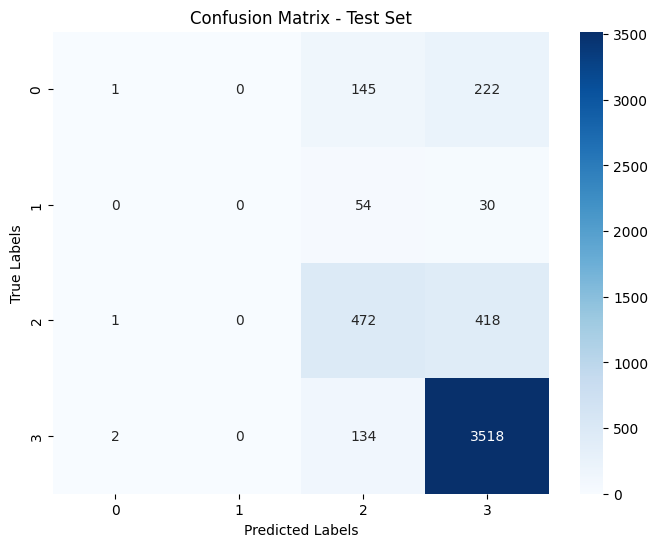


Model saved as 'logistic_regression_stance_model.pkl'
Scaler saved as 'scaler.pkl'


In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure that the data is split properly and check the sizes
print(f"Training data size: {X_train.shape[0]}")
print(f"Test data size: {X_test.shape[0]}")
print(f"Validation data size: {X_val.shape[0]}")

# 1. Preprocessing: Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# 2. Initialize and train Logistic Regression model
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg.fit(X_train_scaled, y_train)

# 3. Predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)
y_val_pred = log_reg.predict(X_val_scaled)

# 5. Accuracy Scores
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
val_accuracy = accuracy_score(y_val, y_val_pred)

print("\n=== Accuracy Scores ===")
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# 6. Confusion Matrix for Test Set
print("\n=== Confusion Matrix for Test Set ===")
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=log_reg.classes_, yticklabels=log_reg.classes_)
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 7. Save the trained model
joblib.dump(log_reg, 'logistic_regression_stance_model.pkl')
print("\nModel saved as 'logistic_regression_stance_model.pkl'")

# 8. Save the scaler (for later use on new data)
joblib.dump(scaler, 'scaler.pkl')
print("Scaler saved as 'scaler.pkl'")


In [17]:
# 1. Check column names to ensure the correct text column
print("Train Data Columns:", X_train.columns)
print("Test Data Columns:", X_test.columns)
print("Validation Data Columns:", X_val.columns)


Train Data Columns: Index(['entity_overlap', 'headline_person_count', 'headline_org_count',
       'body_person_count', 'body_org_count', 'headline_sentiment',
       'body_sentiment'],
      dtype='object')
Test Data Columns: Index(['entity_overlap', 'headline_person_count', 'headline_org_count',
       'body_person_count', 'body_org_count', 'headline_sentiment',
       'body_sentiment'],
      dtype='object')
Validation Data Columns: Index(['entity_overlap', 'headline_person_count', 'headline_org_count',
       'body_person_count', 'body_org_count', 'headline_sentiment',
       'body_sentiment'],
      dtype='object')


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:34:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  if not lib_paths:


Training Accuracy (XGBoost): 0.8634
Test Accuracy (XGBoost): 0.8395
Validation Accuracy (XGBoost): 0.8361
Confusion Matrix for Test Set (XGBoost):


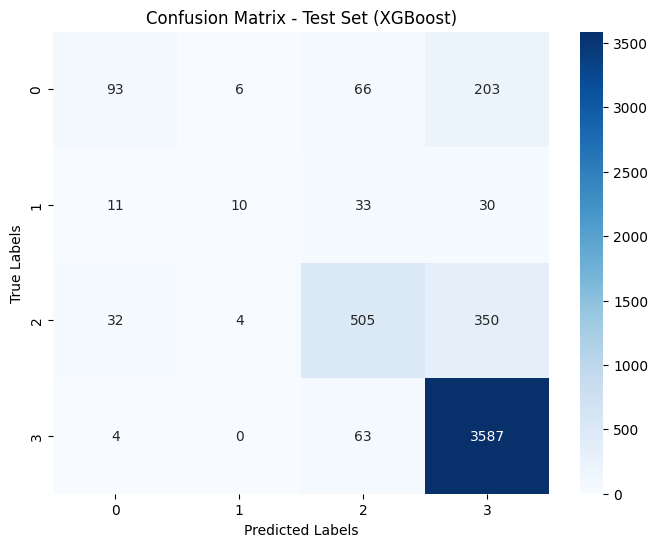

XGBoost model saved as 'xgboost_stance_model.pkl'
Scaler saved as 'scaler_xgb.pkl'


In [21]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize and train XGBoost model
xgb_model = xgb.XGBClassifier(eval_metric='mlogloss', random_state=42, use_label_encoder=False)
xgb_model.fit(X_train_scaled, y_train)

# 2. Predictions
y_train_pred_xgb = xgb_model.predict(X_train_scaled)
y_test_pred_xgb = xgb_model.predict(X_test_scaled)
y_val_pred_xgb = xgb_model.predict(X_val_scaled)


# 4. Accuracy Scores
train_accuracy_xgb = accuracy_score(y_train, y_train_pred_xgb)
test_accuracy_xgb = accuracy_score(y_test, y_test_pred_xgb)
val_accuracy_xgb = accuracy_score(y_val, y_val_pred_xgb)

print(f"Training Accuracy (XGBoost): {train_accuracy_xgb:.4f}")
print(f"Test Accuracy (XGBoost): {test_accuracy_xgb:.4f}")
print(f"Validation Accuracy (XGBoost): {val_accuracy_xgb:.4f}")

# 5. Confusion Matrix
print("Confusion Matrix for Test Set (XGBoost):")
cm_xgb = confusion_matrix(y_test, y_test_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap="Blues", xticklabels=xgb_model.classes_, yticklabels=xgb_model.classes_)
plt.title('Confusion Matrix - Test Set (XGBoost)')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# 6. Save the trained model
joblib.dump(xgb_model, 'xgboost_stance_model.pkl')
print("XGBoost model saved as 'xgboost_stance_model.pkl'")

# 7. Save the scaler (for later use on new data)
joblib.dump(scaler, 'scaler_xgb.pkl')
print("Scaler saved as 'scaler_xgb.pkl'")


/anaconda/envs/azureml_py38/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'pre_classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/anaconda/envs/azureml_py38/lib/python3.10/site-packages/accelerate/accelerator.py:451: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed

Epoch,Training Loss,Validation Loss
1,0.469500,0.315968
2,0.245100,0.300225


Checkpoint destination directory ./results/checkpoint-500 already exists and is non-empty.Saving will proceed but saved results may be invalid.
Checkpoint destination directory ./results/checkpoint-1000 already exists and is non-empty.Saving will proceed but saved results may be invalid.
2024/12/22 16:33:17 INFO mlflow.tracking._tracking_service.client: 🏃 View run ./results at: https://germanywestcentral.api.azureml.ms/mlflow/v2.0/subscriptions/1575d3d8-448d-42e2-b4d7-046abd13ef0a/resourceGroups/festina.qorrolli-rg/providers/Microsoft.MachineLearningServices/workspaces/fake-news-detection/#/experiments/66b00c20-dd83-40c0-ace4-b5e2e9ce1b02/runs/dc7cb2b5-d7cf-4b2b-a8e8-746a8527d199.
2024/12/22 16:33:17 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: https://germanywestcentral.api.azureml.ms/mlflow/v2.0/subscriptions/1575d3d8-448d-42e2-b4d7-046abd13ef0a/resourceGroups/festina.qorrolli-rg/providers/Microsoft.MachineLearningServices/workspaces/fake-news-detection/#/expe

Training Accuracy: 0.9355
Test Accuracy: 0.9020
Validation Accuracy: 0.9020


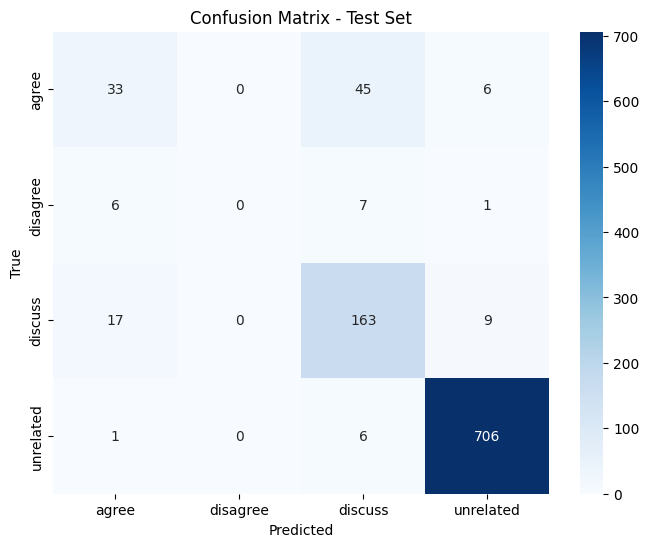

Model and tokenizer saved successfully!


In [4]:
# ===== Step 1: Load and preprocess the dataset =====
import pandas as pd

# Load train_stances.csv and train_bodies.csv
stances = pd.read_csv("train_stances.csv")
bodies = pd.read_csv("train_bodies.csv")

# Merge datasets on the 'Body ID' column
data = pd.merge(stances, bodies, on="Body ID")

# Use a subset of the data for demonstration
data = data.sample(frac=0.1, random_state=42)

# Preprocess data
data['label'] = data['Stance'].map({'agree': 0, 'disagree': 1, 'discuss': 2, 'unrelated': 3})
data = data[['Headline', 'articleBody', 'label']]  # Keep relevant columns

# Train-test split
from sklearn.model_selection import train_test_split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    list(zip(data['Headline'], data['articleBody'])), data['label'], test_size=0.2, random_state=42
)

# ===== Step 2: Tokenize and encode examples =====
from transformers import DistilBertTokenizer
from datasets import Dataset

def encode_examples(texts, labels, tokenizer, max_length=512):
    encodings = tokenizer(
        [f"{t[0]} [SEP] {t[1]}" for t in texts],
        truncation=True, padding=True, max_length=max_length
    )
    dataset = Dataset.from_dict({"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"], "labels": labels})
    return dataset

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased")
train_dataset = encode_examples(train_texts, train_labels, tokenizer)
test_dataset = encode_examples(test_texts, test_labels, tokenizer)

# ===== Step 3: Load the model and set up training =====
from transformers import DistilBertForSequenceClassification, Trainer, TrainingArguments

model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=4)

training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    weight_decay=0.01,
    save_strategy="epoch",
    load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    tokenizer=tokenizer,
)

# ===== Step 4: Train and evaluate the model =====
trainer.train()

# ===== Step 5: Calculate training accuracy =====
from sklearn.metrics import accuracy_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Predict on the training dataset
train_predictions = trainer.predict(train_dataset)
train_pred_labels = np.argmax(train_predictions.predictions, axis=1)
train_true_labels = train_labels.to_numpy()
train_accuracy = accuracy_score(train_true_labels, train_pred_labels)

# ===== Step 6: Calculate test accuracy =====
test_predictions = trainer.predict(test_dataset)
test_pred_labels = np.argmax(test_predictions.predictions, axis=1)
test_true_labels = test_labels.to_numpy()
test_accuracy = accuracy_score(test_true_labels, test_pred_labels)

# ===== Step 7: Calculate validation accuracy =====
# In this case, the test dataset is used for validation as no separate validation set exists
val_accuracy = test_accuracy  # Replace with a separate validation set if available

# ===== Step 8: Print accuracies =====
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# ===== Step 9: Plot confusion matrix for the test set =====
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['agree', 'disagree', 'discuss', 'unrelated'], yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.title('Confusion Matrix - Test Set')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# ===== Step 10: Save the trained model and tokenizer =====
model.save_pretrained("./stance-detection-model")
tokenizer.save_pretrained("./stance-detection-tokenizer")

print("Model and tokenizer saved successfully!")


In [5]:
import pandas as pd

fake_news = pd.read_csv("fake_news.csv")
real_news = pd.read_csv("real_news.csv")

# Print columns of the datasets
print("Columns in fake_news dataset:")
print(fake_news.columns)

print("\nColumns in real_news dataset:")
print(real_news.columns)

# Describe the datasets
print("\nDescription of fake_news dataset:")
print(fake_news.describe(include='all'))

print("\nDescription of real_news dataset:")
print(real_news.describe(include='all'))


Columns in fake_news dataset:
Index(['title', 'text', 'subject', 'date'], dtype='object')

Columns in real_news dataset:
Index(['title', 'text', 'subject', 'date'], dtype='object')

Description of fake_news dataset:
                                                    title   text subject  \
count                                               23481  23481   23481   
unique                                              17903  17455       6   
top     MEDIA IGNORES Time That Bill Clinton FIRED His...           News   
freq                                                    6    626    9050   

                date  
count          23481  
unique          1681  
top     May 10, 2017  
freq              46  

Description of real_news dataset:
                                                    title  \
count                                               21417   
unique                                              20826   
top     Factbox: Trump fills top jobs for his administ...   
freq     

Training Accuracy: 0.9912
Testing Accuracy: 0.9880
Validation Accuracy: 0.9875

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3553
           1       0.98      0.99      0.99      3182

    accuracy                           0.99      6735
   macro avg       0.99      0.99      0.99      6735
weighted avg       0.99      0.99      0.99      6735



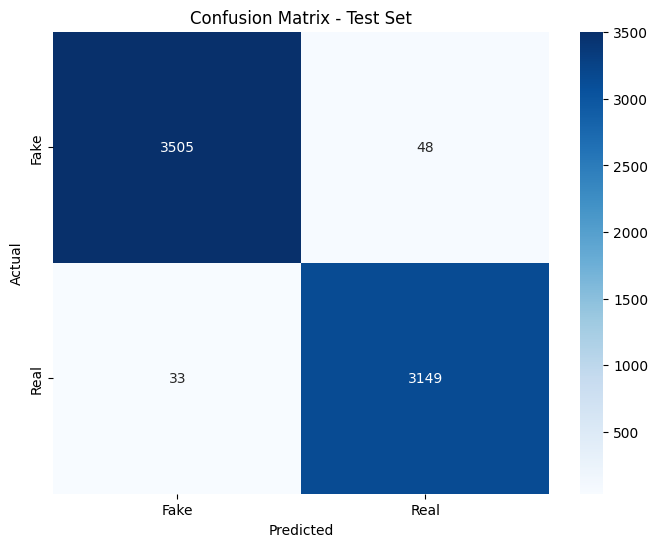

In [6]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ====== Step 1: Dataset Reading and Preprocessing ======

# Load the datasets
fake_news = pd.read_csv("fake_news.csv")
real_news = pd.read_csv("real_news.csv")

# Ensure required columns are present
required_columns = ['title', 'text']
for col in required_columns:
    assert col in fake_news.columns, f"Missing column in fake_news: {col}"
    assert col in real_news.columns, f"Missing column in real_news: {col}"

# Add a label column for stance (1 for real, 0 for fake)
fake_news['Stance'] = 0
real_news['Stance'] = 1

# Combine the two datasets
data = pd.concat([fake_news, real_news], ignore_index=True)

# Combine 'title' and 'text' into a single feature
data['combined_text'] = data['title'] + " " + data['text']

# Define features and target
X = data['combined_text']  # Features: combined text
y = data['Stance']  # Target: Stance

# Split into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ====== Step 2: Feature Transformation ======

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, transform the test and validation data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Save the vectorizer for future use
joblib.dump(tfidf_vectorizer, "log_tfidf_vectorizer.pkl")

# ====== Step 3: Logistic Regression Model Training ======

# Initialize the Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)

# Train the model
log_reg.fit(X_train_tfidf, y_train)

# Save the trained model
joblib.dump(log_reg, "logistic_regression_stance_model.pkl")

# ====== Step 4: Model Evaluation ======

# Predict on the training set
y_train_pred = log_reg.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on the test set
y_test_pred = log_reg.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Predict on the validation set
y_val_pred = log_reg.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate a classification report for the test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Training Accuracy: 1.0000
Testing Accuracy: 0.9972
Validation Accuracy: 0.9988

Classification Report (Test Set):
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3553
           1       1.00      1.00      1.00      3182

    accuracy                           1.00      6735
   macro avg       1.00      1.00      1.00      6735
weighted avg       1.00      1.00      1.00      6735



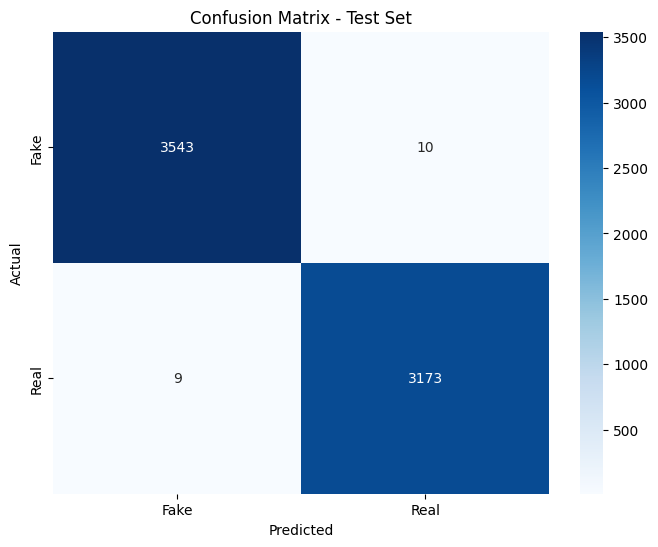

In [7]:
import pandas as pd
import joblib
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# ====== Step 1: Dataset Reading and Preprocessing ======

# Load the datasets
fake_news = pd.read_csv("fake_news.csv")
real_news = pd.read_csv("real_news.csv")

# Ensure required columns are present
required_columns = ['title', 'text']
for col in required_columns:
    assert col in fake_news.columns, f"Missing column in fake_news: {col}"
    assert col in real_news.columns, f"Missing column in real_news: {col}"

# Add a label column for stance (1 for real, 0 for fake)
fake_news['Stance'] = 0
real_news['Stance'] = 1

# Combine the two datasets
data = pd.concat([fake_news, real_news], ignore_index=True)

# Combine 'title' and 'text' into a single feature
data['combined_text'] = data['title'] + " " + data['text']

# Define features and target
X = data['combined_text']  # Features: combined text
y = data['Stance']  # Target: Stance

# Split into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ====== Step 2: Feature Transformation ======

# Initialize a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

# Fit and transform the training data, transform the test and validation data
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)
X_val_tfidf = tfidf_vectorizer.transform(X_val)

# Save the vectorizer for future use
joblib.dump(tfidf_vectorizer, "xgb_tfidf_vectorizer.pkl")

# ====== Step 3: XGBoost Model Training ======

# Initialize the XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_model.fit(X_train_tfidf, y_train)

# Save the trained model
joblib.dump(xgb_model, "xgboost_stance_model.pkl")

# ====== Step 4: Model Evaluation ======

# Predict on the training set
y_train_pred = xgb_model.predict(X_train_tfidf)
train_accuracy = accuracy_score(y_train, y_train_pred)

# Predict on the test set
y_test_pred = xgb_model.predict(X_test_tfidf)
test_accuracy = accuracy_score(y_test, y_test_pred)

# Predict on the validation set
y_val_pred = xgb_model.predict(X_val_tfidf)
val_accuracy = accuracy_score(y_val, y_val_pred)

# Print the accuracies
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Generate a classification report for the test set
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_test_pred))

# Confusion matrix for the test set
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Sample predictions: [3, 2, 2, 2, 2, 2, 2, 2, 2, 2]
Sample true labels: [0, 0, 1, 1, 1, 1, 1, 0, 1, 1]
Sample predictions: [2, 0, 2, 2, 2, 2, 2, 3, 2, 0]
Sample true labels: [1, 0, 1, 1, 1, 0, 0, 0, 1, 0]
Sample predictions: [3, 2, 3, 2, 2, 3, 3, 2, 3, 2]
Sample true labels: [0, 1, 0, 1, 0, 0, 0, 1, 1, 0]
Training Accuracy: 0.0724
Testing Accuracy: 0.0704
Validation Accuracy: 0.0701


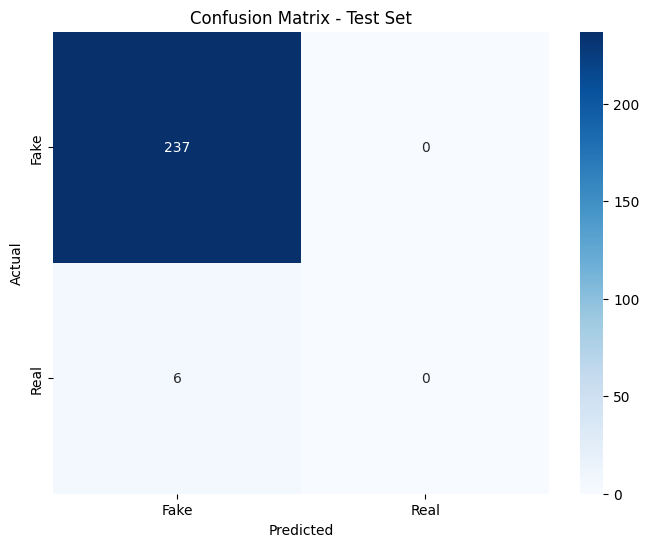

In [2]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# ====== Step 1: Dataset Reading and Preprocessing ======

# Load the datasets
fake_news = pd.read_csv("fake_news.csv")
real_news = pd.read_csv("real_news.csv")

# Ensure required columns are present
required_columns = ['title', 'text']
for col in required_columns:
    assert col in fake_news.columns, f"Missing column in fake_news: {col}"
    assert col in real_news.columns, f"Missing column in real_news: {col}"

# Add a label column for stance (1 for real, 0 for fake)
fake_news['Stance'] = 0
real_news['Stance'] = 1

# Combine the two datasets
data = pd.concat([fake_news, real_news], ignore_index=True)
data = data.sample(frac=0.5, random_state=42)  # Use 1% of data for testing

# Combine 'title' and 'text' into a single feature
data['combined_text'] = data['title'] + " " + data['text']

# Define features and target
X = data['combined_text'].tolist()  # Features: combined text
y = data['Stance'].tolist()  # Target: Stance

# Split into train, test, and validation sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# ====== Step 2: Load the DistilBERT Model and Tokenizer ======

# Load the pre-trained DistilBERT model and tokenizer from the saved folder
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DistilBertForSequenceClassification.from_pretrained("./stance-detection-model").to(device)
tokenizer = DistilBertTokenizer.from_pretrained("./stance-detection-tokenizer")

# ====== Step 3: Tokenize and Encode the Dataset ======

def encode_texts(texts, tokenizer, max_length=256):
    """Tokenize and encode the dataset."""
    encodings = tokenizer(
        texts, truncation=True, padding=True, max_length=max_length, return_tensors="pt"
    )
    return encodings

def create_data_loader(X, y, batch_size=16, max_length=256):
    """Create a PyTorch DataLoader for batching."""
    encodings = encode_texts(X, tokenizer, max_length=max_length)
    labels = torch.tensor(y)
    dataset = torch.utils.data.TensorDataset(encodings["input_ids"], encodings["attention_mask"], labels)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size)

# Create DataLoaders
train_loader = create_data_loader(X_train, y_train)
test_loader = create_data_loader(X_test, y_test)
val_loader = create_data_loader(X_val, y_val)

# ====== Step 4: Evaluate the Model ======

def evaluate_model(model, data_loader):
    model.eval()
    predictions = []
    true_labels = []

    with torch.no_grad():
        for batch in data_loader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, axis=1)

            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    # Print a sample of predictions and true labels
    print("Sample predictions:", predictions[:10])
    print("Sample true labels:", true_labels[:10])

    accuracy = accuracy_score(true_labels, predictions)
    return predictions, true_labels, accuracy

# Evaluate model
_, train_labels, train_accuracy = evaluate_model(model, train_loader)
test_predictions, test_labels, test_accuracy = evaluate_model(model, test_loader)
_, val_labels, val_accuracy = evaluate_model(model, val_loader)

# ====== Step 5: Print Accuracies ======
print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Testing Accuracy: {test_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# ====== Step 7: Plot Confusion Matrix ======
conf_matrix = confusion_matrix(test_labels, test_predictions, labels=[0, 1])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
plt.title("Confusion Matrix - Test Set")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
